In [115]:
# General
import string
import numpy as np
import pandas as pd
import warnings

# Ignore warnings in libraries
warnings.filterwarnings("ignore")

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, KeyedVectors
from gensim.models.wrappers import LdaMallet
from gensim.test.utils import datapath
# Lemmatization
import spacy

# Plotting tools
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [172]:
data = pd.read_csv("~/Desktop/Svevo/carteggio.svevo3.csv", sep=';', parse_dates=['date'])
nlp_it = spacy.load("it", disable=['parser', 'ner'])
stop_words = set(['schmitz', 'signore', 'signora', 'ettore', 'lettera', 'parola', 'fare', 'cosa' , 'acqua' , 'sera' , 'bepi' , 'mattina' , 'mano','trieste'])

In [134]:
def preprocess_text(text, nlp, stop_words = [], pos = ['PROPN', 'NOUN', 'ADJ']):
    """
    Performs preprocessing on a text through spaCy, langauge based on nlp parameter.
    Filter default stopword plus those in the list stop_words,
    accepts only word with POS tag in the pos list,
    filters out non-alpha words, performs lemmatization.
    Returns a list of lemmatized, filtered tokens for the text.
    """
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.lemma_ not in stop_words and token.pos_ in pos and not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_)
    return tokens

def create_lda_model(dictionary, corpus, num_topics, num_words = 20, passes = 20):
    """
    Creates an LDA model using gensim.
    Dictionary and corpus should be obtained with corpora.
    Number of topics and number of passes should be tweaked depending on context.
    """
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
    for topic,words in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=num_words):
        print(str(topic)+ ": " + words + "\n")
    return lda_model

def get_lda_keywords(model, num_words = 20):
    """
    Extract the firt num_words keywords from all topics of a gensim LDA model.
    """
    num_topics = len(model.print_topics())
    return [[tup2[0] for tup2 in tup[1]]for tup in model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words)]
    
def create_paper_points_data(lda_model, corpus, num_topics):
    """
    Creates a dataframe with topic scores for each text in corpus using a gensim LDA model.
    """
    x = [[] for i in range(num_topics)]
    for text in corpus:
        l_tup = lda_model[text]
        for val in range(num_topics):
            added = False
            for tup in l_tup:
                if tup[0] == val:
                    x[val].append(tup[1])
                    added = True
            if added == False:
                x[val].append(0)
    df = pd.DataFrame(x)
    df = df.transpose()
    df.columns = ['Topic' + str(n) for n in range(num_topics)]
    return df

def compute_silhouette(lda_model, corpus, num_topics):
    """
    Computes silhouette index for an LDA model based on topics it classified.
    """
    points = create_paper_points_data(lda_model, corpus, num_topics).values
    lda_labels = points.argmax(axis=1) 
    return silhouette_score(points, lda_labels)
    
def compute_perplexity(lda_model, corpus):
    """
    Computes perplexity score for an LDA model.
    """
    perplexity = lda_model.log_perplexity(corpus)
    return perplexity

def compute_coherence(lda_model, texts, corpus, dictionary, coherence = "c_v"):
    """
    Computes coherence score for an LDA model.
    """
    score = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence=coherence).get_coherence()
    return score


In [135]:
data_it = data[data.mainLanguage == "ITA"]
texts_it = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_it["text"]]
d_it = corpora.Dictionary(texts_it)
d_it.filter_extremes(no_below=5, no_above=0.5)
c_it = [d_it.doc2bow(text) for text in texts_it]


In [128]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus, num_topics, id2word=dictionary, passes=200, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [136]:
model_list , coherence_values = compute_coherence_values(d_it, c_it , texts_it , 6 , 3 , 1)

In [139]:
vis = pyLDAvis.gensim.prepare(model_list[1] , c_it , d_it)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.116799 -0.081605       1        1  40.393448
1      0.236740 -0.038276       2        1  22.037193
0     -0.087035 -0.064193       3        1  19.919392
2     -0.032906  0.184074       4        1  17.649966, topic_info=            Term        Freq       Total Category  logprob  loglift
113       londra  184.000000  184.000000  Default  30.0000  30.0000
72      senilità  122.000000  122.000000  Default  29.0000  29.0000
50       amicare  132.000000  132.000000  Default  28.0000  28.0000
150   articolare  117.000000  117.000000  Default  27.0000  27.0000
63       librare  107.000000  107.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
372         onta   29.654421   70.934463   Topic4  -5.2707   0.8623
173        posto   29.572773   71.897015   Topic4  -5.2734   0.8461
374      ragione   31.149251  112.138350   Topic4  -5.2215   0.4535
1044        olga   35.165974  217.780157   Topic4  -5.1002  -0.0890
306       curare   29.849081  110.160380   Topic4  -5.2641   0.4287

[266 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
849       1  0.806564  abbracciare
849       2  0.009433  abbracciare
849       3  0.122635  abbracciare
849       4  0.056601  abbracciare
519       2  0.979938          aff
...     ...       ...          ...
273       1  0.040804        villa
273       2  0.952102        villa
1328      1  0.947177      zanzara
102       2  0.984996         zeno
1274      1  0.980708          zia

[441 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

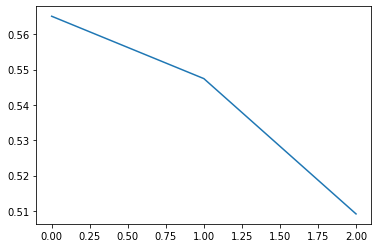

In [166]:
plt.plot(coherence_values)

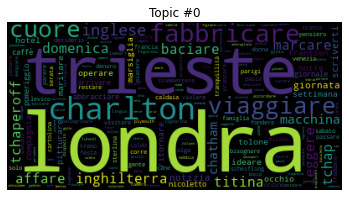

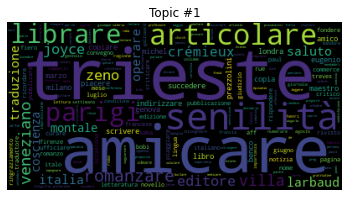

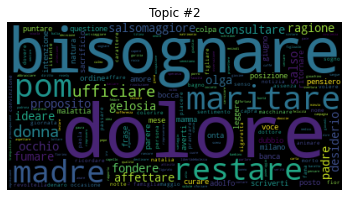

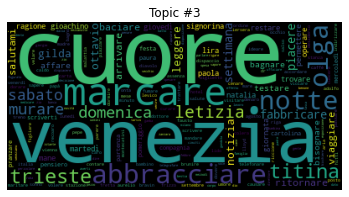

In [171]:
import wordcloud
from wordcloud import WordCloud

for t in range(model_list[1].num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(model_list[1].show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [165]:
model_list[1].show_topic(t, 200)


[('londra', 0.023087341), ('trieste', 0.013907718), ('charlton', 0.013882744), ('fabbricare', 0.013358564), ('viaggiare', 0.011313669), ('cuore', 0.011010182), ('inglese', 0.009988747), ('leggere', 0.008351365), ('titina', 0.007426824), ('inghilterra', 0.007074788), ('domenica', 0.0070386515), ('marcare', 0.0068893074), ('baciare', 0.0068864133), ('tchap', 0.006785557), ('affare', 0.00659703), ('tchaperoff', 0.0064825546), ('macchina', 0.0063454662), ('chatham', 0.0061996714), ('giornata', 0.0061686393), ('scriverti', 0.0059501715), ('notizia', 0.005885404), ('settimana', 0.005869736), ('marsiglia', 0.005757102), ('tolone', 0.0054656398), ('notte', 0.004988557), ('ideare', 0.0049384176), ('frantzen', 0.004878853), ('operare', 0.0047676633), ('pitturare', 0.00472863), ('compagnia', 0.0044853482), ('ritornare', 0.004168109), ('hotel', 0.004069111), ('occhio', 0.0040336144), ('maritare', 0.004029384), ('abbracciare', 0.0039819507), ('arrivare', 0.003940269), ('giornale', 0.0039254613), ('

SyntaxError: unexpected EOF while parsing (<ipython-input-170-c996d25f4948>, line 1)